In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from json import JSONDecodeError
from pandas import json_normalize
import os
import time
from pathlib import Path
import ipywidgets as widgets
from datetime import datetime, timedelta

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
!kaggle competitions download -c mlb-player-digital-engagement-forecasting

__init__.py: Skipping, found more recently modified local copy (use --force to force download)
competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
players.csv: Skipping, found more recently modified local copy (use --force to force download)
seasons.csv: Skipping, found more recently modified local copy (use --force to force download)
example_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
awards.csv: Skipping, found more recently modified local copy (use --force to force download)
teams.csv: Skipping, found more recently modified local copy (use --force to force download)
train_updated.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
example_test.csv.zip: Skipping, found more recently modified local copy (use --force t

# ESTRAZIONE DATI

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
zip_ref.extractall('')
zip_ref.close()

JSON TO DATAFRAME

In [ ]:
def json_to_df(df, column):
    
    num_rows = len(df)
    
    data_list = []
    for row in range(num_rows):
        
        json_data = df.iloc[row][column]
        if str(json_data) != "nan": #we don't want to append NA values in the dataframes
            data = pd.read_json(json_data)
            data_list.append(data)
        
    all_data = pd.concat(data_list, axis = 0)
    
    num_rows = len(all_data)
    num_cols = len(all_data.columns)
    mem_usage = all_data.memory_usage(deep = True).sum()
    
    print(f"{column}: {num_rows} rows; {num_cols} cols; {mem_usage} bytes.")
    return all_data

**CSV TO PANDAS DF - STATIC DATAFRAME**

In [ ]:
data_dir = Path('/content/')
dfs_static = ['seasons', 'teams', 'players', 'awards']

for name in dfs_static:
    globals()[name] = pd.read_csv(data_dir / f"{name}.csv")

data_tabs = widgets.Tab()
# Add Output widgets for each pandas DF as tabs' children
data_tabs.children = list([widgets.Output() for df_name in dfs_static])

for index in range(0, len(dfs_static)):
    # Rename tab bar titles to df names
    data_tabs.set_title(index, dfs_static[index])
    
    # Display corresponding table output for this tab name
    with data_tabs.children[index]:
        display(eval(dfs_static[index]))

display(data_tabs)

In [ ]:
train = pd.read_csv('/content/train.csv')

TRAIN SET - DATI GIORNALIERI


In [ ]:
train.head(3)

,date,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
0,20180101,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
1,20180102,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2,20180103,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN


In [ ]:
dfs_train = ['nextDayPlayerEngagement',
             #'games',
             #'rosters',
             'playerBoxScores',
             #'teamBoxScores',
             #'transactions',
             #'standings',
             #'awards',
             'events',
             #'playerTwitterFollowers',
             #'teamTwitterFollowers']

for name in dfs_train:
    globals()[name] = json_to_df(train, name)

  widget_train_tab = widgets.Tab()
  widget_train_tab.children = list([widgets.Output() for df_name in dfs_train])

  for index in range(0, len(dfs_train)):
    widget_train_tab.set_title(index, dfs_train[index])

    with widget_train_tab.children[index]:
    display(eval(dfs_train[index]))

  display(widget_train_tab)

In [ ]:
targets = json_to_df(train, 'nextDayPlayerEngagement')
pscores = json_to_df(train, 'playerBoxScores')

nextDayPlayerEngagement: 2506176 rows; 6 cols; 288210240 bytes.
playerBoxScores: 185144 rows; 85 cols; 201409700 bytes.


In [ ]:
targets = targets.rename(columns={'engagementMetricsDate':'date'})
pscores = pscores.rename(columns={'gameDate':'date'})

In [ ]:
games = json_to_df(train, 'games')

games: 7860 rows; 32 cols; 7708781 bytes.


In [ ]:
games = games.rename(columns={'gameDate':'date'})

In [ ]:
games.head()

,gamePk,gameType,season,date,gameTimeUTC,resumeDate,resumedFrom,codedGameState,detailedGameState,isTie,gameNumber,doubleHeader,dayNight,scheduledInnings,gamesInSeries,seriesDescription,homeId,homeName,homeAbbrev,homeWins,homeLosses,homeWinPct,homeWinner,homeScore,awayId,awayName,awayAbbrev,awayWins,awayLosses,awayWinPct,awayWinner,awayScore
0,533782,E,2018,2018-02-21,2018-02-21T20:10:00Z,NaN,NaN,F,Final,0.0,1,N,day,7,0.0,Exhibition,109,Arizona Diamondbacks,ARI,1,0,1.0,True,7.0,5035,Arizona State Sun Devils,ASU,0.0,1.0,0.0,False,2.0
0,534461,E,2018,2018-02-22,2018-02-22T18:05:00Z,NaN,NaN,F,Final,0.0,1,N,day,9,0.0,Exhibition,116,Detroit Tigers,DET,1,0,1.0,True,6.0,228,Florida Southern College Mocs,FSC,0.0,1.0,0.0,False,1.0
1,545334,E,2018,2018-02-22,2018-02-22T18:05:00Z,NaN,NaN,F,Final,0.0,1,N,day,9,0.0,Exhibition,143,Philadelphia Phillies,PHI,1,0,1.0,True,6.0,231,University of Tampa Spartans,UT,0.0,1.0,0.0,False,0.0
2,547295,E,2018,2018-02-22,2018-02-22T03:33:00Z,NaN,NaN,F,Final,0.0,2,Y,night,9,0.0,Exhibition,111,Boston Red Sox,BOS,2,0,1.0,True,4.0,227,Boston College Eagles,BC,0.0,1.0,0.0,False,2.0
3,533784,E,2018,2018-02-22,2018-02-22T23:05:00Z,NaN,NaN,F,Final,0.0,1,N,night,9,0.0,Exhibition,142,Minnesota Twins,MIN,1,0,1.0,True,2.0,4864,Minnesota Gophers,UM,0.0,1.0,0.0,False,1.0


In [ ]:
games.drop(['gameTimeUTC', 'resumeDate','resumedFrom','codedGameState','detailedGameState','isTie','gameNumber','dayNight','seriesDescription',
            'homeName','homeAbbrev','awayName','awayAbbrev'], axis=1, inplace=True)

In [ ]:
games.columns

Index(['gamePk', 'gameType', 'season', 'date', 'doubleHeader',
       'scheduledInnings', 'gamesInSeries', 'homeId', 'homeWins', 'homeLosses',
       'homeWinPct', 'homeWinner', 'homeScore', 'awayId', 'awayWins',
       'awayLosses', 'awayWinPct', 'awayWinner', 'awayScore'],
      dtype='object')

In [ ]:
#parsing datatime
nextDayPlayerEngagement = nextDayPlayerEngagement.rename(columns={'engagementMetricsDate':'date'})

games = games.rename(columns={'gameDate':'date'})

rosters = rosters.rename(columns={'gameDate':'date'})

playerBoxScores = playerBoxScores.rename(columns={'gameDate':'date'})

teamBoxScores = teamBoxScores.rename(columns={'gameDate':'date'})

standings = standings.rename(columns={'gameDate':'date'})
standings['date']= pd.to_datetime(standings['date'])

awards = awards.rename(columns={'awardDate':'date'})

events = events.rename(columns={'gameDate':'date'})

TARGETS

In [ ]:
nextDayPlayerEngagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506176 entries, 0 to 2060
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   playerId  int64  
 2   target1   float64
 3   target2   float64
 4   target3   float64
 5   target4   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 133.8+ MB


In [ ]:
nextDayPlayerEngagement['date']= pd.to_datetime(nextDayPlayerEngagement['date'])

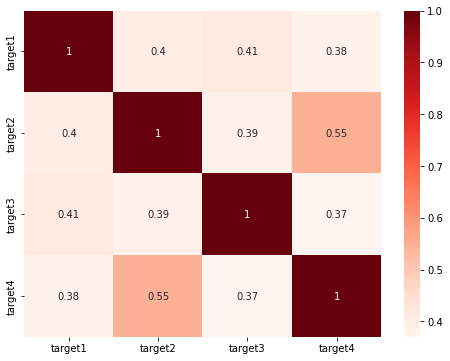

In [ ]:
#CORRELAZIONE DEI TARGET
plt.figure(figsize=(8,6))
corr = nextDayPlayerEngagement[['target1','target2','target3','target4']].corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#analyse events
targets_events = pd.merge(targets, events, on=['date'], how='left')

In [ ]:
#JOINING TARGET E FEATURES(PLAYER BOX SCORES)
target_playerscores = pd.merge(pscores[["hits",
    "strikeOuts",
    "homeRuns",
    "runsScored",
    "stolenBases",
    "strikeOutsPitching",
    "inningsPitched",
    "strikes",
    "flyOuts",
    "groundOuts",
    "errors",
    "assists",
    "chances",
    "rbi","date","playerId","teamId"]], targets, on=['date','playerId'], how='right')

In [ ]:
target_playerscores.head(3)

,hits,strikeOuts,homeRuns,runsScored,stolenBases,strikeOutsPitching,inningsPitched,strikes,flyOuts,groundOuts,errors,assists,chances,rbi,date,playerId,teamId,target1,target2,target3,target4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,628317,NaN,0.011167,4.474708,0.005168,5.735294
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,547989,NaN,0.042993,5.593385,0.045033,2.794118
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,519317,NaN,0.974327,56.177043,13.693746,64.166667


In [ ]:
engage_playerscores_info = engage_playerscores.copy()
engage_playerscores_info['targetMean'] = np.mean(engage_playerscores_info[['target1','target2','target3','target4']], axis=1)

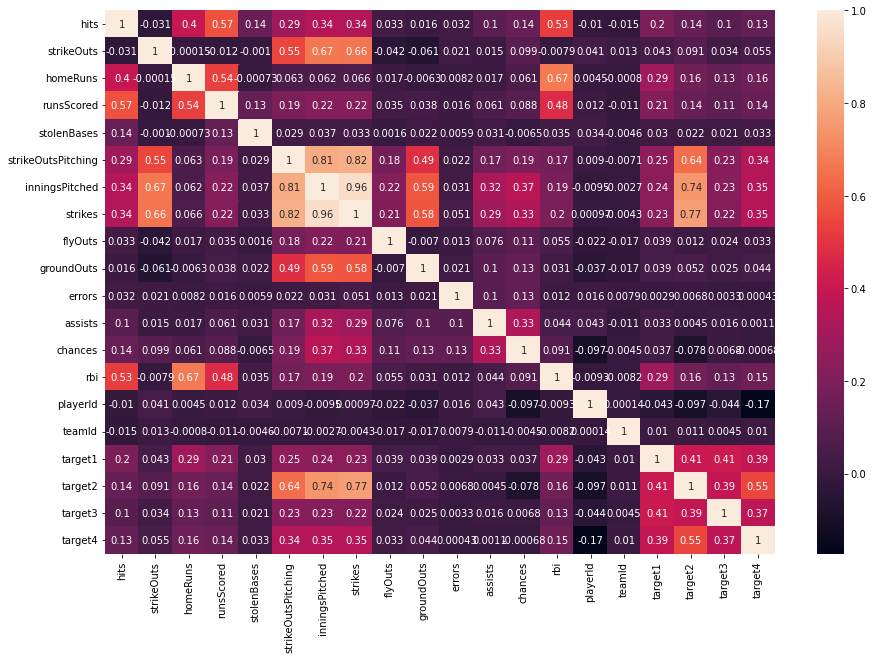

In [ ]:
plt.figure(figsize=(15,10))
corr_pscores_targets = target_playerscores.corr()
sns.heatmap(corr_pscores_targets, annot=True)
plt.show()

features importanti PlayerBoxScores: 'strikeOutPitching' 'inningsPitched' 'strikes''rbi' 'homeRuns' 'groundsOut' 'strikesOut' 'hits' 'runsScored'

In [ ]:
#games corr
target_games = pd.merge(targets, games, on=['date'],how='left')

In [ ]:
plt.figure(figsize=(15,10))
corr_games_targets = target_games.corr()
sns.heatmap(corr_pscores_targets, annot=True)
plt.show()

AWARDS

In [ ]:
awards.head()

,awardId,awardName,date,awardSeason,playerId,playerName,awardPlayerTeamId
0,VWLCPOY,VWL Comeback Player of the Year,2018-01-15,2017,150119,Freddy Garcia,699.0
1,VWLPOY,VWL Pitcher of the Year,2018-01-15,2017,446861,Guillermo Moscoso,699.0
2,VWLMOY,VWL Manager of the Year,2018-01-15,2017,492527,Mike Rojas,695.0
3,VWLRLOY,VWL Reliever of the Year,2018-01-15,2017,519246,Andres Santiago,694.0
4,VWLOPOY,VWL Offensive Player of the Year,2018-01-15,2017,543874,Jose Vargas,699.0


In [ ]:
awards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5915 entries, 0 to 7
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   awardId            5915 non-null   object 
 1   awardName          5915 non-null   object 
 2   date               5915 non-null   object 
 3   awardSeason        5915 non-null   int64  
 4   playerId           5915 non-null   int64  
 5   playerName         5915 non-null   object 
 6   awardPlayerTeamId  5884 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 369.7+ KB


In [ ]:
awards['date']= pd.to_datetime(awards['date'])
awards = awards.astype({'awardId': str})

In [ ]:
awards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5915 entries, 0 to 7
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   awardId            5915 non-null   object        
 1   awardName          5915 non-null   object        
 2   date               5915 non-null   datetime64[ns]
 3   awardSeason        5915 non-null   int64         
 4   playerId           5915 non-null   int64         
 5   playerName         5915 non-null   object        
 6   awardPlayerTeamId  5884 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 369.7+ KB


In [ ]:
target_awards = pd.merge(nextDayPlayerEngagement, awards, on=['date','playerId'], how='inner')

Un player che vince un awards è protagonista di un valore molto importante per il target

In [ ]:
target_awards.head(10)

,date,playerId,target1,target2,target3,target4,awardId,awardName,awardSeason,playerName,awardPlayerTeamId
0,2018-02-19,623214,0.000000,0.008887,0.000000,0.000000,CSAS,Caribbean Series All-Star,2018,Abiatal Avelino,1191.0
1,2018-02-19,553902,0.002620,0.462099,0.000000,0.000000,CSAS,Caribbean Series All-Star,2018,Willians Astudillo,1193.0
2,2018-04-01,475253,92.019798,25.782669,8.472089,30.903156,ALPOW,AL Player of the Week,2018,Justin Smoak,141.0
3,2018-04-01,594809,4.931865,20.971458,9.095064,12.963696,NLPOW,NL Player of the Week,2018,Adam Eaton,120.0
4,2018-04-08,660271,73.104370,100.000000,100.000000,100.000000,ALPOW,AL Player of the Week,2018,Shohei Ohtani,108.0
5,2018-04-08,592791,11.425622,10.658582,6.103009,4.284551,NLPOW,NL Player of the Week,2018,Jameson Taillon,134.0
6,2018-04-15,647304,0.000484,0.103464,0.000000,0.085616,TEXPOWH,TEX Player of the Week,2018,Josh Naylor,510.0
7,2018-04-15,665489,0.013660,0.140415,0.018419,0.631421,EASPOWH,EAS Player of the Week,2018,Vladimir Guerrero Jr.,463.0
8,2018-04-15,453286,1.473600,11.716017,5.911486,2.157802,NLPOW,NL Player of the Week,2018,Max Scherzer,120.0
9,2018-04-15,592468,0.000121,0.103464,0.003070,0.005351,INTPOWP,INT Pitcher of the Week,2018,Nick Kingham,484.0


STANDINGS

In [ ]:
standings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15930 entries, 0 to 29
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   season                     15930 non-null  int64         
 1   date                       15930 non-null  datetime64[ns]
 2   divisionId                 15930 non-null  int64         
 3   teamId                     15930 non-null  int64         
 4   teamName                   15930 non-null  object        
 5   streakCode                 15833 non-null  object        
 6   divisionRank               15930 non-null  int64         
 7   leagueRank                 15930 non-null  int64         
 8   wildCardRank               12516 non-null  float64       
 9   leagueGamesBack            15930 non-null  object        
 10  sportGamesBack             15930 non-null  object        
 11  divisionGamesBack          15930 non-null  object        
 12  wins   

In [ ]:
#'wins', 'losses', 'lastTenWins', 'lastTenLosses', 'oneRunLosses', 'oneRunWins', 'leagueRank', 'wildCardRank', 'pct'

In [ ]:
standings['date']= pd.to_datetime(standings['date'])

In [ ]:
#engage_playerscores_info['date']= pd.to_datetime(engage_playerscores_info['date'])

In [ ]:
standings_target = pd.merge(engage_playerscores_info, standings[['wins','losses',
                                                                 'lastTenWins','lastTenLosses',
                                                                 'oneRunLosses','oneRunWins',
                                                                 'leagueRank','wildCardRank','pct','date','teamId']], on=['date','teamId'], how='inner')

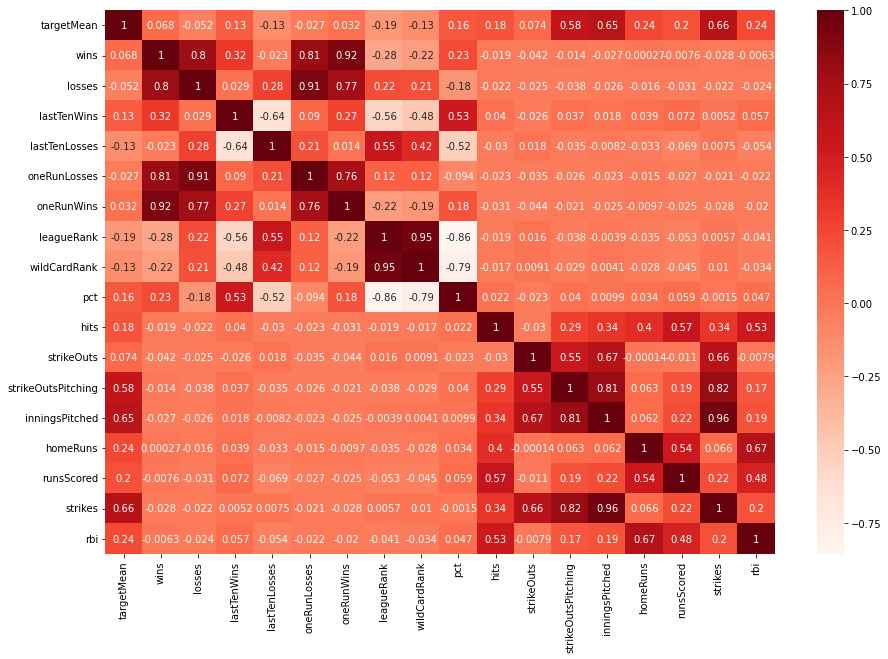

In [ ]:
plt.figure(figsize=(15,10))
corr_target_standings = target_standings.corr()
sns.heatmap(corr_target_standings, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
engage_playerscores_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184759 entries, 0 to 184758
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   hits                153369 non-null  float64       
 1   strikeOuts          153369 non-null  float64       
 2   homeRuns            153369 non-null  float64       
 3   runsScored          153369 non-null  float64       
 4   stolenBases         153369 non-null  float64       
 5   strikeOutsPitching  55178 non-null   float64       
 6   inningsPitched      55178 non-null   float64       
 7   strikes             55178 non-null   float64       
 8   flyOuts             153369 non-null  float64       
 9   groundOuts          153369 non-null  float64       
 10  errors              150420 non-null  float64       
 11  date                184759 non-null  datetime64[ns]
 12  playerId            184759 non-null  int64         
 13  teamId              184759 no

In [ ]:
playerTwitterFollowers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39589 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               39589 non-null  datetime64[ns]
 1   playerId           39589 non-null  int64         
 2   playerName         39589 non-null  object        
 3   accountName        39589 non-null  object        
 4   twitterHandle      39589 non-null  object        
 5   numberOfFollowers  39589 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.1+ MB


In [ ]:
teamTwitterFollowers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1200 non-null   datetime64[ns]
 1   teamId             1200 non-null   int64         
 2   teamName           1200 non-null   object        
 3   accountName        1200 non-null   object        
 4   twitterHandle      1200 non-null   object        
 5   numberOfFollowers  1200 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 65.6+ KB


In [ ]:
nextDayPlayerEngagement['date']= pd.to_datetime(nextDayPlayerEngagement['date'])

In [ ]:
engage_playerscores_info['date']= pd.to_datetime(engage_playerscores_info['date'])

In [ ]:
playerTwitterFollowers = playerTwitterFollowers.rename(columns={'numberOfFollowers':'playerFollowers'})

In [ ]:
#teamTwitterFollowers = teamTwitterFollowers.rename(columns={'numberOfFollowers':'teamFollowers'})

In [ ]:
followers_target = pd.merge(engage_playerscores_info, playerTwitterFollowers, on=['date','playerId'], how='inner')

In [ ]:
#followers_target = pd.merge(followers_target, teamTwitterFollowers, on=['date', 'teamId'], how='inner')

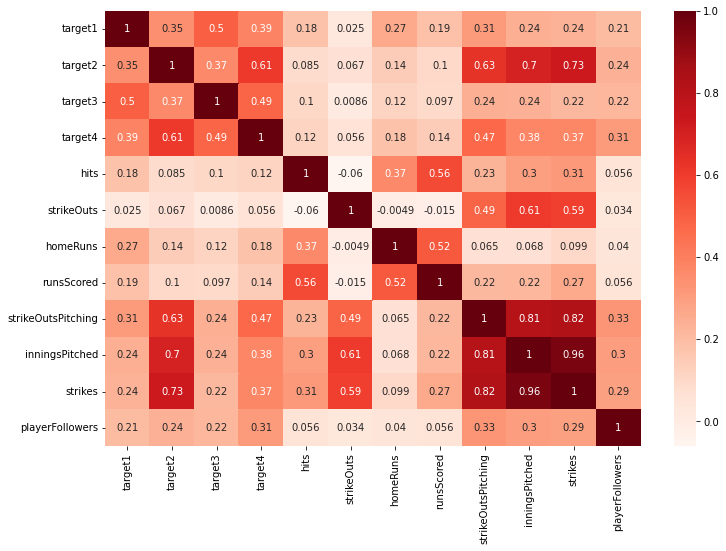

In [ ]:
plt.figure(figsize=(12,8))
corr_target_followers = followers_target[['target1','target2','target3','target4',
    "hits",
    "strikeOuts",
    "homeRuns",
    "runsScored",
    "strikeOutsPitching",
    "inningsPitched",
    "strikes",
    "playerFollowers"]].corr()
sns.heatmap(corr_target_followers, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
teamBoxScores['date']= pd.to_datetime(teamBoxScores['date'])

proviamo a vedere come i target e le features possono essere correlate raggruppando le informazioni per singoli giorni.(in questo modo si può vedere meglio come si muovono i dati in base alla media di tutti i giocatori per quel giorno).

In [ ]:
#raggruppamento per giorno (si prendono le features più interessanti (corr>0.2))
engangeByDay = standings_target.groupby('date', as_index=True)[['targetMean','wins','losses','lastTenWins','lastTenLosses',
                                            'oneRunLosses','oneRunWins','leagueRank','wildCardRank','pct',
                                            "hits","strikeOuts","strikeOutsPitching","inningsPitched","homeRuns","runsScored",'strikes','rbi']].mean()

In [ ]:
engangeByDay.head(3)

,targetMean,wins,losses,lastTenWins,lastTenLosses,oneRunLosses,oneRunWins,leagueRank,wildCardRank,pct,hits,strikeOuts,strikeOutsPitching,inningsPitched,homeRuns,runsScored,strikes,rbi
date,,,,,,,,,,,,,,,,,,
2018-03-29,3.866102,0.498765,0.501235,0.498765,0.501235,0.192593,0.197531,8.014815,7.769821,0.498765,0.622024,0.744048,1.880597,1.680597,0.098214,0.339286,18.805970,0.324405
2018-03-30,4.114020,0.897361,0.914956,0.897361,0.914956,0.390029,0.404692,8.164223,7.080128,0.494135,0.606780,0.664407,1.781818,1.920909,0.050847,0.288136,20.618182,0.274576
2018-03-31,5.252205,1.326781,1.319410,1.326781,1.319410,0.515971,0.545455,7.958231,7.492063,0.500410,0.693410,0.659026,1.878049,1.878862,0.091691,0.398281,21.544715,0.381089


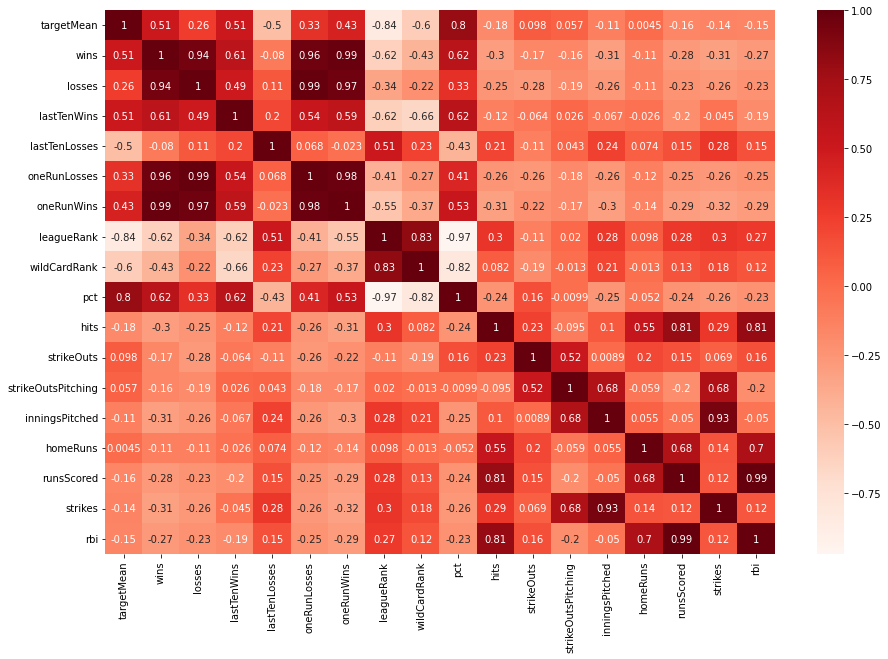

In [ ]:
plt.figure(figsize=(15,10))
corr_avg = engangeByDay.corr()
sns.heatmap(corr_avg,annot=True,cmap=plt.cm.Reds)
plt.show()

le features "playerboxscore" rimangono tra le più importanti e fondamentali. quasi tutte sono importanti per l'andamento del target

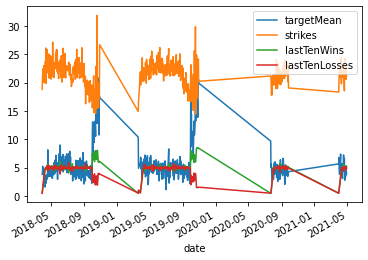

In [ ]:
engangeByDay[['targetMean','strikes','lastTenWins','lastTenLosses']].plot()
plt.show()

In [ ]:
lastest_engage = standings_target[standings_target['date']>='2021-01-01']

In [ ]:
lastest_engage['strikes']=='3.0'

171885    False
171886    False
171887    False
171888    False
171889    False
          ...  
182950    False
182951    False
182952    False
182953    False
182954    False
Name: strikes, Length: 11070, dtype: bool

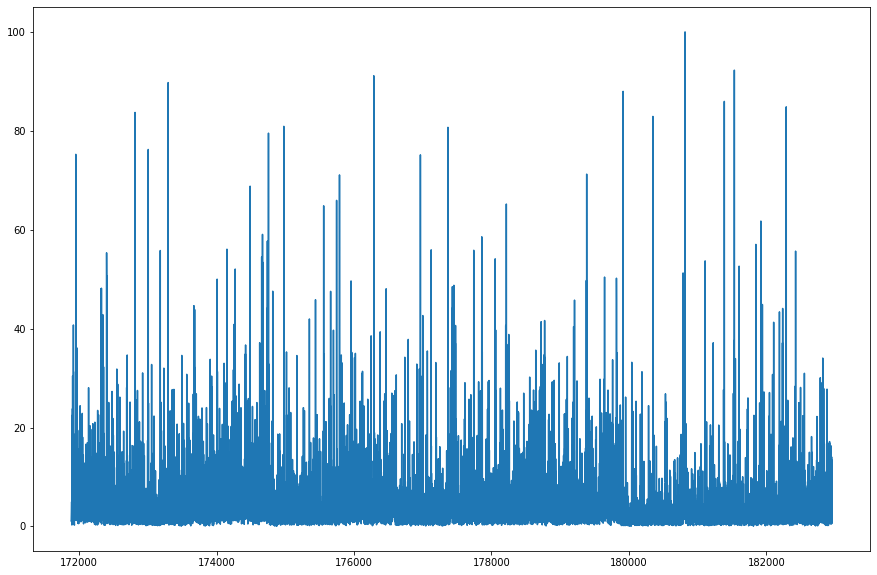

In [ ]:
plt.figure(figsize=(15,10))
lastest_engage['targetMean'].plot()
plt.show()

TRANSACTION


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41030 entries, 0 to 47
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transactionId   41030 non-null  int64         
 1   playerId        40655 non-null  float64       
 2   playerName      40653 non-null  object        
 3   date            41030 non-null  datetime64[ns]
 4   fromTeamId      14078 non-null  float64       
 5   fromTeamName    14078 non-null  object        
 6   toTeamId        41030 non-null  int64         
 7   toTeamName      41030 non-null  object        
 8   effectiveDate   41030 non-null  object        
 9   resolutionDate  28166 non-null  object        
 10  typeCode        41030 non-null  object        
 11  typeDesc        41030 non-null  object        
 12  description     41011 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 4.4+ MB


In [ ]:
target_transactions = pd.merge(nextDayPlayerEngagement, transactions, on=['date','playerId'], how='inner')

In [ ]:
target_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26605 entries, 0 to 26604
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            26605 non-null  datetime64[ns]
 1   playerId        26605 non-null  int64         
 2   target1         26605 non-null  float64       
 3   target2         26605 non-null  float64       
 4   target3         26605 non-null  float64       
 5   target4         26605 non-null  float64       
 6   transactionId   26605 non-null  int64         
 7   playerName      26605 non-null  object        
 8   fromTeamId      12720 non-null  float64       
 9   fromTeamName    12720 non-null  object        
 10  toTeamId        26605 non-null  int64         
 11  toTeamName      26605 non-null  object        
 12  effectiveDate   26605 non-null  object        
 13  resolutionDate  15071 non-null  object        
 14  typeCode        26605 non-null  object        
 15  ty

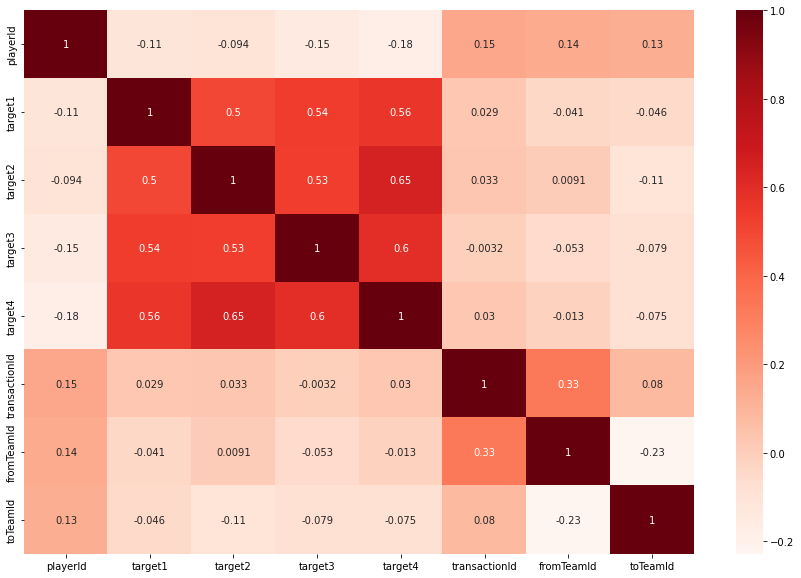

In [ ]:
plt.figure(figsize=(15,10))
corr_target_transactions = target_transactions.corr()
sns.heatmap(corr_target_transactions, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
engage_transaction.head()

,transactionId,playerId,playerName,date,fromTeamId,fromTeamName,toTeamId,toTeamName,effectiveDate,resolutionDate,typeCode,typeDesc,description,target1,target2,target3,target4
0,341123,607054.0,Jace Peterson,2018-01-02,NaN,None,147,New York Yankees,2018-01-02,2018-01-02,SFA,Signed as Free Agent,New York Yankees signed free agent 2B Jace Pet...,0.000558,1.799611,0.000000,1.029412
1,339518,571697.0,Scooter Gennett,2018-01-03,NaN,NaN,113,Cincinnati Reds,2018-01-03,2018-01-03,NUM,Number Change,Scooter Gennett changed number to 3.,0.027379,2.981838,0.056029,1.082707
2,339517,605520.0,Mitch Walding,2018-01-03,NaN,NaN,143,Philadelphia Phillies,2018-01-03,2018-01-03,ASG,Assigned,Philadelphia Phillies invited non-roster 3B Mi...,0.000000,3.415560,0.000000,0.000000
3,339502,465753.0,Pedro Florimon,2018-01-03,NaN,NaN,143,Philadelphia Phillies,2018-01-03,2018-01-03,SFA,Signed as Free Agent,Philadelphia Phillies signed free agent CF Ped...,0.701099,7.779886,3.826442,0.601504
4,339549,545343.0,Louis Head,2018-01-04,NaN,None,114,Cleveland Indians,2018-01-04,2018-01-04,ASG,Assigned,Cleveland Indians invited non-roster RHP Louis...,0.000000,1.671245,0.000000,0.000000
